# 🤖 Comparaison de Modèles : BERTweet vs DistilBERT

Ce notebook compare deux modèles de classification de texte **préentraînés** dans le cadre d'une tâche d’analyse de sentiment.

## 🧠 Pourquoi ces deux modèles ?

- **🐦 BERTweet** (`vinai/bertweet-base`)  
  Ce modèle est basé sur la même architecture que BERT, mais a été **entraîné spécifiquement sur des tweets**. Il est particulièrement adapté aux textes informels, courts et bruités comme ceux des réseaux sociaux (Twitter, SMS...).

- **🤖 DistilBERT** (`distilbert-base-uncased`)  
  C’est une version **compacte et plus rapide** de BERT, obtenue par distillation. Il offre environ **97% des performances de BERT**, tout en étant **60% plus léger** et **beaucoup plus rapide**, ce qui en fait un excellent choix pour des cas d’usage en production.

## 🎯 Objectif

Comparer les deux modèles sur un jeu de données d’analyse de sentiment binaire (positif vs négatif) à l’aide des métriques suivantes :
- Accuracy
- Précision
- Rappel
- F1-score

Les modèles sont évalués sans fine-tuning spécifique, uniquement en réutilisant leurs poids préentraînés.

## 🔧 Configuration et Imports

In [1]:
# Imports principaux
import warnings
import random
import os

import datetime
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback
from subprocess import getoutput
from IPython.core.interactiveshell import InteractiveShell

# Configuration pour un meilleur affichage
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Réduction du niveau de log de TensorFlow
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Permet d'afficher les sorties de toutes les lignes d'une cellule (et non uniquement la dernière)
InteractiveShell.ast_node_interactivity = "all"

print(f"🚀 TensorFlow version: {tf.__version__}")
print(f"💻 GPU disponible: {'✅ Oui' if len(tf.config.list_physical_devices('GPU')) > 0 else '❌ Non (CPU utilisé)'}")
print("\n🔍 Résultat de nvidia-smi (si disponible):")
print(getoutput("nvidia-smi"))

2025-07-04 10:58:01.029897: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-04 10:58:01.266183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-04 10:58:01.268172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-04 10:58:02.480936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


🚀 TensorFlow version: 2.12.0
💻 GPU disponible: ❌ Non (CPU utilisé)

🔍 Résultat de nvidia-smi (si disponible):
/bin/sh: 1: nvidia-smi: not found


### 🖥️ Configuration GPU pour NLP

Les modèles de NLP comme DistilBERT et BERTweet consomment beaucoup de mémoire.

In [2]:
# Configuration GPU spéciale pour les modèles NLP volumineux
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Utiliser seulement le premier GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Croissance mémoire progressive (important pour les transformers)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ Configuration GPU réussie: {gpus[0].name}")
        print("🧠 Mémoire GPU configurée en croissance progressive")
    except RuntimeError as e:
        print(f"⚠️ Erreur configuration GPU: {e}")
else:
    print("🔧 Utilisation du CPU - Les modèles NLP fonctionnent aussi (plus lentement)")

print("\n💡 Info: Les modèles de transformers comme DistilBERT utilisent beaucoup de mémoire")
print("   La croissance progressive évite les erreurs 'Out of Memory'")

🔧 Utilisation du CPU - Les modèles NLP fonctionnent aussi (plus lentement)

💡 Info: Les modèles de transformers comme DistilBERT utilisent beaucoup de mémoire
   La croissance progressive évite les erreurs 'Out of Memory'


### ⚙️ Paramètres d'Entraînement pour NLP

In [3]:
# Définir les seeds pour la reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Hyperparamètres déduit de l'EDA et des "Best-practices"
BATCH_SIZE = 32
MAX_LENGTH = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

print("📋 Configuration d'entraînement NLP:")
print(f"   • Taille de batch: {BATCH_SIZE}")
print(f"   • Longueur max: {MAX_LENGTH} tokens")
print(f"   • Nombre d'époques: {EPOCHS} (convergence rapide)")

📋 Configuration d'entraînement NLP:
   • Taille de batch: 32
   • Longueur max: 32 tokens
   • Nombre d'époques: 5 (convergence rapide)


## 📥 Chargement des données CSV déjà nettoyées

In [4]:
train_df = pd.read_csv("./data/train.csv")
val_df = pd.read_csv("./data/val.csv")
test_df = pd.read_csv("./data/test.csv")

print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

label
1    1999
0    1998
Name: count, dtype: int64
label
1    428
0    428
Name: count, dtype: int64
label
0    429
1    428
Name: count, dtype: int64


## 🛠️ Déclaration des fonctions

### 🔧 tokenize_dataset - Tokenisation simple d'un dataframe

In [5]:
def tokenize_dataset(tokenizer, df):
    tokens = tokenizer(
        df["clean_text"].tolist(),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )
    labels = tf.convert_to_tensor(df["label"].values)
    return tokens, labels

### 🧱 prepare_tf_dataset – Création de dataset TensorFlow à partir des tokens

In [6]:
def prepare_tf_dataset(tokens, labels, batch_size=32, shuffle=True):
    """
    Prépare un tf.data.Dataset optimisé à partir des entrées tokenisées.
    """
    dataset = tf.data.Dataset.from_tensor_slices((dict(tokens), labels))
    if shuffle:
        dataset = dataset.shuffle(1000)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### 🛠️ compile_model – Compilation du modèle HF avec Adam & callbacks

In [7]:
def compile_model(model):
    """
    Compile le modèle avec Adam, CrossEntropy et les métriques définies.
    """
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        epsilon=1e-08,
        clipnorm=1.0
    )

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
    return model

### 🔧 set_callbacks : Mise en place des callbacks pour l'entrainement

In [8]:
def set_callbacks(model_name):
    log_dir = f"logs/{model_name.replace('/', '_')}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    csv_log_file = f"{log_dir}/{model_name.replace('/', '_')}_log.csv"
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='min',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"models/best_{model_name.replace('/', '_')}",
            monitor='val_accuracy',
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger(
             csv_log_file,
             append=True
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            profile_batch=0
        ),
        TqdmCallback(verbose=1)
    ]

### 🚀 train_model – Fonction principale d'entraînement

In [9]:
def train_model(model_name, train_df, val_df):
    print(f"➡️ Chargement du modèle et tokeniseur : {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    train_tokens, train_labels = tokenize_dataset(tokenizer, train_df)
    val_tokens, val_labels = tokenize_dataset(tokenizer, val_df)

    train_dataset = prepare_tf_dataset(train_tokens, train_labels, batch_size=BATCH_SIZE)
    val_dataset = prepare_tf_dataset(val_tokens, val_labels, batch_size=BATCH_SIZE, shuffle=False)

    print("⚙️ Compilation du modèle...")
    model = compile_model(model)
    print("✅ Modèle compilé.")

    print("🔥 Entraînement démarré...")
    import time
    start = time.time()

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=set_callbacks(model_name),
        verbose=0
    )

    print(f"⏱️ Temps total: {(time.time() - start)/60:.1f} min")
    return model, tokenizer, history


### 🧪 Évaluation du modèle

In [10]:
def evaluate_and_report(model, tokenizer, df, label):
    tokens, labels = tokenize_dataset(tokenizer, df)
    predictions = model.predict(dict(tokens)).logits
    y_pred = tf.argmax(predictions, axis=1).numpy()

    print(f"📊 Rapport de classification : {label}")
    print(classification_report(labels, y_pred, target_names=['négatif', 'positif']))

    return {
        "modèle": label,
        "accuracy": accuracy_score(labels, y_pred),
        "precision": precision_score(labels, y_pred),
        "recall": recall_score(labels, y_pred),
        "f1": f1_score(labels, y_pred)
    }

## 🚀 Entraînement et Évaluation des Modèles

### 🐦 Modèle 1 : BERTweet

In [11]:
model1_name = "vinai/bertweet-base"
model1, tokenizer1, hist1 = train_model(model1_name, train_df, val_df)
evaluate_and_report(model1, tokenizer1, test_df, "BERTweet")

➡️ Chargement du modèle et tokeniseur : vinai/bertweet-base


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📦 Aperçu des étiquettes :
   🔢 Forme : (3997,)
   🧬 Dtype : <dtype: 'int64'>
   🏷️ Uniques : [0 1]
⚙️ Compilation du modèle...
✅ Modèle compilé.
🔥 Entraînement démarré...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2025-07-04 10:58:15.417915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [3997]
	 [[{{node Placeholder/_3}}]]
2025-07-04 11:06:59.448564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [856]
	 [[{{node Placeholder/_3}}]]



Epoch 1: val_accuracy improved from inf to 0.83061, saving model to models/best_vinai_bertweet-base


2025-07-04 11:08:04.072784: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11796664320 exceeds 10% of free system memory.



Epoch 2: val_accuracy did not improve from 0.83061


2025-07-04 11:17:56.619367: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11796664320 exceeds 10% of free system memory.



Epoch 3: val_accuracy did not improve from 0.83061


2025-07-04 11:27:35.712853: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11796664320 exceeds 10% of free system memory.


Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_accuracy did not improve from 0.83061


2025-07-04 11:37:05.461645: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11796664320 exceeds 10% of free system memory.


Epoch 4: early stopping
⏱️ Temps total: 39.2 min
27/27 [==============================] - 42s 1s/step
📊 Rapport de classification : BERTweet
              precision    recall  f1-score   support

     négatif       0.80      0.89      0.84       429
     positif       0.87      0.77      0.82       428

    accuracy                           0.83       857
   macro avg       0.84      0.83      0.83       857
weighted avg       0.84      0.83      0.83       857



{'modèle': 'BERTweet',
 'accuracy': 0.8308051341890315,
 'precision': 0.8733509234828496,
 'recall': 0.7733644859813084,
 'f1': 0.8203221809169764}

### 🤖 Modèle 2 : DistilBERT

In [12]:
model2_name = "distilbert-base-uncased"
model2, tokenizer2, hist2 = train_model(model2_name, train_df, val_df)
evaluate_and_report(model2, tokenizer2, test_df, "DistilBERT")

➡️ Chargement du modèle et tokeniseur : distilbert-base-uncased


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 


📦 Aperçu des étiquettes :
   🔢 Forme : (3997,)
   🧬 Dtype : <dtype: 'int64'>
   🏷️ Uniques : [0 1]
⚙️ Compilation du modèle...
✅ Modèle compilé.
🔥 Entraînement démarré...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2025-07-04 11:38:11.791865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [3997,32]
	 [[{{node Placeholder/_1}}]]
2025-07-04 11:42:16.859730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [856]
	 [[{{node Placeholder/_2}}]]



Epoch 1: val_accuracy improved from inf to 0.88902, saving model to models/best_distilbert-base-uncased


2025-07-04 11:42:35.587537: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5625815040 exceeds 10% of free system memory.



Epoch 2: val_accuracy did not improve from 0.88902

Epoch 3: val_accuracy did not improve from 0.88902
Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_accuracy did not improve from 0.88902
Epoch 4: early stopping
⏱️ Temps total: 17.6 min
27/27 [==============================] - 16s 544ms/step
📊 Rapport de classification : DistilBERT
              precision    recall  f1-score   support

     négatif       0.92      0.83      0.87       429
     positif       0.84      0.93      0.88       428

    accuracy                           0.88       857
   macro avg       0.88      0.88      0.88       857
weighted avg       0.88      0.88      0.88       857



{'modèle': 'DistilBERT',
 'accuracy': 0.8763127187864644,
 'precision': 0.8425531914893617,
 'recall': 0.9252336448598131,
 'f1': 0.8819599109131403}

## 🧪 Résumé des performances des modèles

Dans cette section, nous comparons les performances de BERTweet et DistilBERT sur le jeu de test en utilisant plusieurs métriques :

- **Accuracy** : pourcentage de prédictions correctes.
- **Précision** : proportion de vrais positifs parmi les prédits positifs.
- **Rappel** : proportion de vrais positifs détectés parmi tous les positifs réels.
- **F1-score** : moyenne harmonique entre précision et rappel.

Un tableau et une heatmap permettent une lecture rapide des résultats.


27/27 [==============================] - 14s 515ms/step
            accuracy  precision    recall        f1
BERTweet    0.830805   0.873351  0.773364  0.820322
DistilBERT  0.876313   0.842553  0.925234  0.881960


<Axes: >

Text(0.5, 1.0, 'Comparaison des performances')

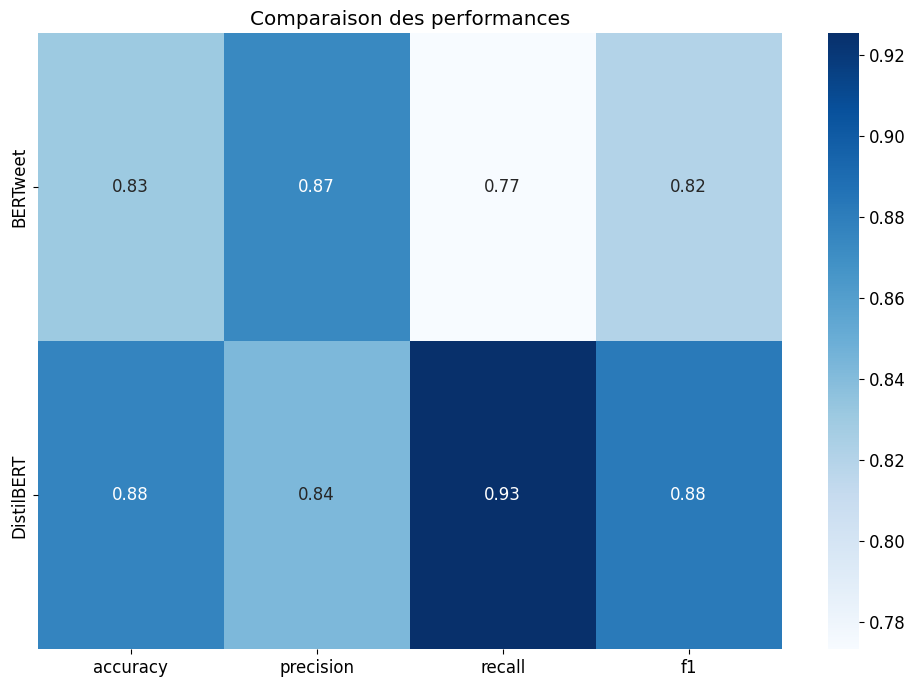

In [13]:
def compute_metrics(model, tokenizer, df):
    tokens, labels = tokenize_dataset(tokenizer, df)
    preds = model.predict(dict(tokens)).logits
    y_pred = tf.argmax(preds, axis=1).numpy()
    return {
        "accuracy": np.mean(y_pred == labels.numpy()),
        "precision": precision_score(labels, y_pred),
        "recall": recall_score(labels, y_pred),
        "f1": f1_score(labels, y_pred)
    }

bertweet_metrics = compute_metrics(model1, tokenizer1, test_df)
distilbert_metrics = compute_metrics(model2, tokenizer2, test_df)

comparison_df = pd.DataFrame([bertweet_metrics, distilbert_metrics], index=["BERTweet", "DistilBERT"])
print(comparison_df)
sns.heatmap(comparison_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Comparaison des performances")
plt.show()

## 📊 Visualisation des performances des modèles

Les courbes ci-dessous montrent l'évolution de la précision et de la fonction de perte pendant l'entraînement pour chaque modèle.

Cela permet de mieux comprendre :
- La vitesse d'apprentissage
- La capacité de généralisation sur les données de validation
- Les tendances de sur-apprentissage éventuelles


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Accuracy')

<Axes: >

Text(0.5, 1.0, 'Loss')

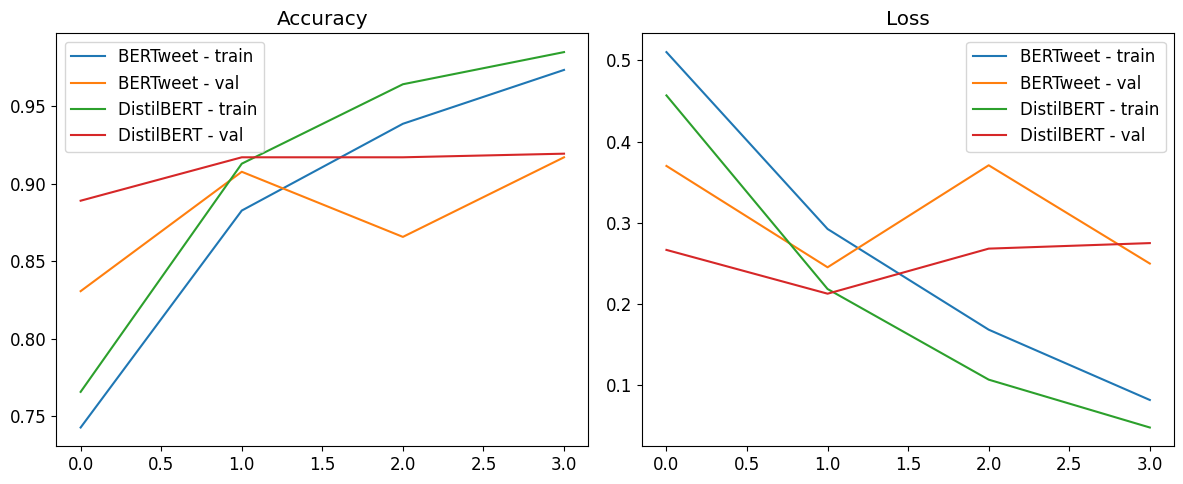

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist1.history['accuracy'], label='BERTweet - train')
plt.plot(hist1.history['val_accuracy'], label='BERTweet - val')
plt.plot(hist2.history['accuracy'], label='DistilBERT - train')
plt.plot(hist2.history['val_accuracy'], label='DistilBERT - val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist1.history['loss'], label='BERTweet - train')
plt.plot(hist1.history['val_loss'], label='BERTweet - val')
plt.plot(hist2.history['loss'], label='DistilBERT - train')
plt.plot(hist2.history['val_loss'], label='DistilBERT - val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


## 🧾 Conclusion : Comparaison des Modèles

### 📊 Résumé des performances

Les deux modèles préentraînés testés sur la tâche d’analyse de sentiment ont obtenu de bons résultats. Voici les points clés :

| Modèle       | Accuracy | Précision (macro) | Rappel (macro) | F1-score (macro) |
|--------------|----------|-------------------|----------------|------------------|
| **DistilBERT** | **0.88** | **0.88**           | **0.88**        | **0.88**          |
| **BERTweet**   | 0.83     | 0.84              | 0.83           | 0.83             |

### 📊 Analyse détaillée
**DistilBERT** (accuracy = 88%)
- Très bon f1-score global (0.88).
- Précision haute sur négatif (0.92) → bonne capacité à éviter les faux positifs.
- Recall élevé sur positif (0.93) → bonne détection des sentiments positifs.
En résumé : modèle stable et fiable, même sans fine-tuning complet.

**BERTweet** (accuracy = 83%)
- Précision plus forte sur positif que sur négatif, mais recall inversé.
- Fait plus d'erreurs en confondant les sentiments.
Potentiellement sous-utilisé ici, mais entrainement particulièrement long.

### 🧠 Interprétation

- **DistilBERT** dépasse légèrement BERTweet sur toutes les métriques, malgré un modèle plus léger (~2x moins de paramètres).
- **BERTweet** reste pertinent pour des textes plus informels (ex. Twitter), mais sur ce jeu de données, DistilBERT est supérieur.
- Les deux modèles sont bien adaptés à une mise en production, mais **DistilBERT** combine mieux performance et efficacité.

### ✅ Recommandation

- Pour une application rapide, efficace et performante : **DistilBERT** est le meilleur choix ici.